In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Get the current directory of the notebook
# and go up one level to the project root ('KINETICCONSTANTS_TEST')
project_root = os.path.abspath("..")

# Add the project root to the system path if it's not there already
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
from torch_geometric.data import Data, Dataset, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, dense_to_sparse
import torch
import torch.nn as nn
import lmdb
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
from model import SimpleGNN, mlp
import os
from simulation.produce_simulations import SimulatedGraphDataset
from simulation.simulator import Simulator, find_cycles_for_edge, add_baths, get_biggest_submatrix

In [21]:
ckpt_dir = '../model_checkpoints'  # Directory to load checkpoints
ckpt = 2
#model = mlp(in_channels=int(num_nodes), out_channel=int(num_edges), hidden_dim=[int(0.5*num_nodes), int(0.3*num_nodes), int(0.2*num_nodes), int(0.1*num_nodes)], hidden_num=4)
model = SimpleGNN(in_channels=2, hidden_channels=64, node_out_channels=1, edge_out_channels=1)
model.load_state_dict(torch.load(os.path.join(ckpt_dir, f'model_checkpoint_epoch_{ckpt}.pt')))
model.eval()

SimpleGNN(
  (embed): mlp(
    (mlp): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): PReLU(num_parameters=1)
      (5): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (graph_encoder): mlp(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): PReLU(num_parameters=1)
      (5): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (convs): ModuleList(
    (0): GCNConv(128, 128)
    (1): GCNConv(128, 64)
  )
  (node_predictor): mlp(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=False)
      (1): PReLU(num_parameters=1)
      (2): Dropout(p=0.1, inplace=False)
      (3): Line

In [22]:
db_path = '../simulation/simulated_graph_small_dataset_only_steady_state_free_energies'
dataset = SimulatedGraphDataset(root=db_path)
torch.manual_seed(42)
dataset = dataset.shuffle()  # Shuffle the dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = dataset[:train_size], dataset[train_size:]
small_test_dataset = test_dataset[:500]
small_train_dataset = train_dataset[:500]

batch_size = 32  # Adjust batch size as needed
test_loader = DataLoader(small_test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
train_loader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [23]:
adj_matrix_df = pd.read_csv('../simulation/adjacency_matrix.csv', index_col=0)
all_lipids = adj_matrix_df.index.tolist()
adj_matrix = np.array(adj_matrix_df)
symmetric_adj_matrix = np.maximum(adj_matrix, adj_matrix.T)
adj_matrix = symmetric_adj_matrix
adj_matrix, _ = get_biggest_submatrix(adj_matrix)
num_edges = np.sum(adj_matrix, dtype=int)
num_nodes = adj_matrix.shape[0]
print(f'Number of edges: {num_edges}')
correlation_matrix_partial = pd.read_csv('../simulation/correlation_matrix.csv', index_col=0)
correlation_matrix = pd.DataFrame(np.eye(len(all_lipids)), index=all_lipids, columns=all_lipids)
L = np.linalg.cholesky(correlation_matrix.values)
big_adj_matrix = add_baths(adj_matrix)

Number of edges: 334


In [ ]:
num_edges = 378
ks_pred = {f'k_{idx}': np.array([]) for idx in range(num_edges)}
ks_true = {f'k_{idx}': np.array([]) for idx in range(num_edges)}

with torch.no_grad():
    for i in range(10):
        for batch in tqdm(test_loader, desc="Evaluating"):
            data = batch.to('cpu')
            node_out, edge_out = model(batch.x, batch.edge_index, batch.batch)
            k_prod, k_deg, sigma_conc, dropout = node_out.split([1, 1, 1, 1], dim=-1)
            k, sigma_k = edge_out.split([1, 1], dim=-1)
            k = k.squeeze(-1)
            k_prod = k_prod.squeeze(-1)
            k_deg = k_deg.squeeze(-1)
            pred = k.cpu().numpy()
            targets = np.array(batch.parameters['sparse_log_kinetic_constants'])
            
            for idx in range(num_edges):
                ks_pred[f'k_{idx}'] = np.append(ks_pred[f'k_{idx}'], np.array(pred[idx::batch.batch_size]))
                ks_true[f'k_{idx}'] = np.append(ks_true[f'k_{idx}'], np.array(targets[idx::batch.batch_size]))

In [ ]:
ks_pred = [np.array([]) for idx in range(num_edges)]
ks_true = [np.array([]) for idx in range(num_edges)]

ks_prod_pred = [np.array([]) for idx in range(num_nodes)]
ks_deg_pred = [np.array([]) for idx in range(num_nodes)]
ks_prod_true = [np.array([]) for idx in range(num_nodes)]
ks_deg_true = [np.array([]) for idx in range(num_nodes)]

with torch.no_grad():
    for batch in tqdm(train_loader, desc="Evaluating"):
        data = batch.to('cpu')
        out_node, out_edge = model(data.x, data.edge_index , data.batch)
        k_prod, k_deg, sigma_conc, dropout = out_node.split([1, 1, 1, 1], dim=-1)
        k, sigma_k = out_edge.split([1, 1], dim=-1)
        k = k.squeeze(-1)
        k_prod = k_prod.squeeze(-1)
        k_deg = k_deg.squeeze(-1)
        pred = k.cpu().numpy()
        targets = np.array(batch.parameters['sparse_log_kinetic_constants']).reshape(-1)
        prod_targets = np.log(np.array(batch.parameters['production_constants']).reshape(-1))
        deg_targets = np.log(np.array(batch.parameters['degradation_constants']).reshape(-1))
    
        for idx in range(num_nodes):
            ks_prod_pred[idx] =  np.append(ks_prod_pred[idx], np.array(k_prod.cpu().numpy()[idx::num_nodes]))
            ks_deg_pred[idx] =  np.append(ks_deg_pred[idx], np.array(k_deg.cpu().numpy()[idx::num_nodes]))
            ks_prod_true[idx] =  np.append(ks_prod_true[idx], np.array(prod_targets[idx::num_nodes]))
            ks_deg_true[idx] =  np.append(ks_deg_true[idx], np.array(deg_targets[idx::num_nodes]))
        
        for idx in range(num_edges):
            ks_pred[idx] = np.append(ks_pred[idx], np.array(pred[idx::num_edges]))
            ks_true[idx] = np.append(ks_true[idx], np.array(targets[idx::num_edges]))

ks_pred = np.array(ks_pred)
ks_true = np.array(ks_true)
ks_prod_pred = np.array(ks_prod_pred)
ks_deg_pred = np.array(ks_deg_pred)
ks_prod_true = np.array(ks_prod_true)
ks_deg_true = np.array(ks_deg_true)

print(ks_pred.shape, ks_true.shape)
print(ks_prod_pred.shape, ks_deg_pred.shape)
print(ks_prod_true.shape, ks_deg_true.shape)

In [24]:
big_num_nodes = 2 * num_nodes
big_num_edges = num_edges + 2 * num_nodes
deltaG_true = [np.array([]) for idx in range(big_num_edges)]
deltaG_pred = [np.array([]) for idx in range(big_num_edges)]
free_energies_true = [np.array([]) for idx in range(big_num_nodes)]
free_energies_pred = [np.array([]) for idx in range(big_num_nodes)]

with torch.no_grad():
    for batch in tqdm(train_loader, desc="Evaluating"):
        node_out, edge_out = model(batch.x, batch.edge_index, batch.batch, free_energies=False, add_baths=False)
        free_energies = node_out.squeeze(-1)
        barrier_heights = edge_out.squeeze(-1)
        
        # Faster: avoid repeated numpy->tensor conversion; use pre-computed mask
        free_energy_true = torch.from_numpy(np.array(batch.parameters['free_energies'])).float()
        free_energy_true = free_energy_true.reshape(-1)
        deltaG_true_batch = torch.from_numpy(np.array(batch.parameters['sparse_all_deltaG'])).float().reshape(-1)
        row, col = batch.edge_index
        deltaG = free_energies[col] - free_energies[row]
        deltaG = barrier_heights

        for idx in range(big_num_edges):
            deltaG_pred[idx] =  np.append(deltaG_pred[idx], np.array(deltaG[idx::big_num_edges]))
            deltaG_true[idx] =  np.append(deltaG_true[idx], np.array(deltaG_true_batch.cpu().numpy()[idx::big_num_edges]))
        for idx in range(big_num_nodes):
            free_energies_pred[idx] =  np.append(free_energies_pred[idx], np.array(free_energies.cpu().numpy()[idx::big_num_nodes]))
            free_energies_true[idx] =  np.append(free_energies_true[idx], np.array(free_energy_true.cpu().numpy()[idx::big_num_nodes]))
deltaG_true = np.array(deltaG_true)
deltaG_pred = np.array(deltaG_pred)
free_energies_true = np.array(free_energies_true)
free_energies_pred = np.array(free_energies_pred)

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]C:\Users\cirob\AppData\Local\Temp\ipykernel_21800\4252485079.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  deltaG_pred[idx] =  np.append(deltaG_pred[idx], np.array(deltaG[idx::big_num_edges]))
Evaluating: 100%|██████████| 16/16 [00:00<00:00, 17.73it/s]


In [25]:
graph = dataset[0]
edges_to_baths = []
for i, edge in enumerate(graph.edge_index.T):
    if edge[0].item() > 82 or edge[1].item() > 82:
        edges_to_baths.append(i)

In [ ]:
edges = np.where(adj_matrix == 1)
edges = list(zip(edges[0], edges[1]))
num_cycles_per_edge = []
for idx in range(np.sum(adj_matrix, dtype=int)):
    cycles = find_cycles_for_edge(edges[idx][0], edges[idx][1], adj_matrix, max_cycle_length=6)
    num_cycles_per_edge.append(np.sum(cycles))
num_cycles_per_edge = np.array(num_cycles_per_edge)

In [26]:
def plot_results(true, pred, title, per_sample=False, indexes=range(40), points_to_color=[]):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(nrows=8, ncols=5, figsize=(20, 32), tight_layout=True)#, subplot_kw={'xscale': 'log', 'yscale': 'log'})
    for i, idx in enumerate(indexes[:40]):
        row = i // 5
        col = i % 5
        if per_sample:
            all_points = list(np.arange(true.shape[0]))
            for x in points_to_color:
                all_points.remove(x)
            true_values = true[all_points, idx]
            pred_values = pred[all_points, idx]
            true_values_to_color = true[points_to_color, idx]
            pred_values_to_color = pred[points_to_color, idx]
            axs[row, col].scatter(true_values, pred_values, alpha=0.5)
            axs[row, col].scatter(true_values_to_color, pred_values_to_color, alpha=0.2, color='red')
        else:
            true_values = true[idx]
            pred_values = pred[idx]
            axs[row, col].scatter(true_values, pred_values, alpha=0.5)
        axs[row, col].plot([min(true_values), max(true_values)],
                        [min(true_values), max(true_values)], 'r--')
        axs[row, col].axhline(y=np.mean(true_values), color='gray', linestyle='dotted')
        axs[row, col].set_title(f'{title}{idx}')
        axs[row, col].set_xlabel('True Values')
        axs[row, col].set_ylabel('Predicted Values')
    plt.show()

In [ ]:
indexes = np.argsort(num_cycles_per_edge)[:40]
plot_results(ks_true, ks_pred, title='Kinetic Constant k_', indexes=indexes)
plot_results(ks_true, ks_pred, title='Sample ', per_sample=True, indexes=indexes)

In [ ]:
plot_results(ks_prod_true, ks_prod_pred, title='Kinetic Constant k_')
plot_results(ks_prod_true, ks_prod_pred, title='Sample ', per_sample=True)

In [ ]:
plot_results(free_energies_true, free_energies_pred, title='Free Energies node ')
plot_results(free_energies_true, free_energies_pred, title='Sample ', per_sample=True)

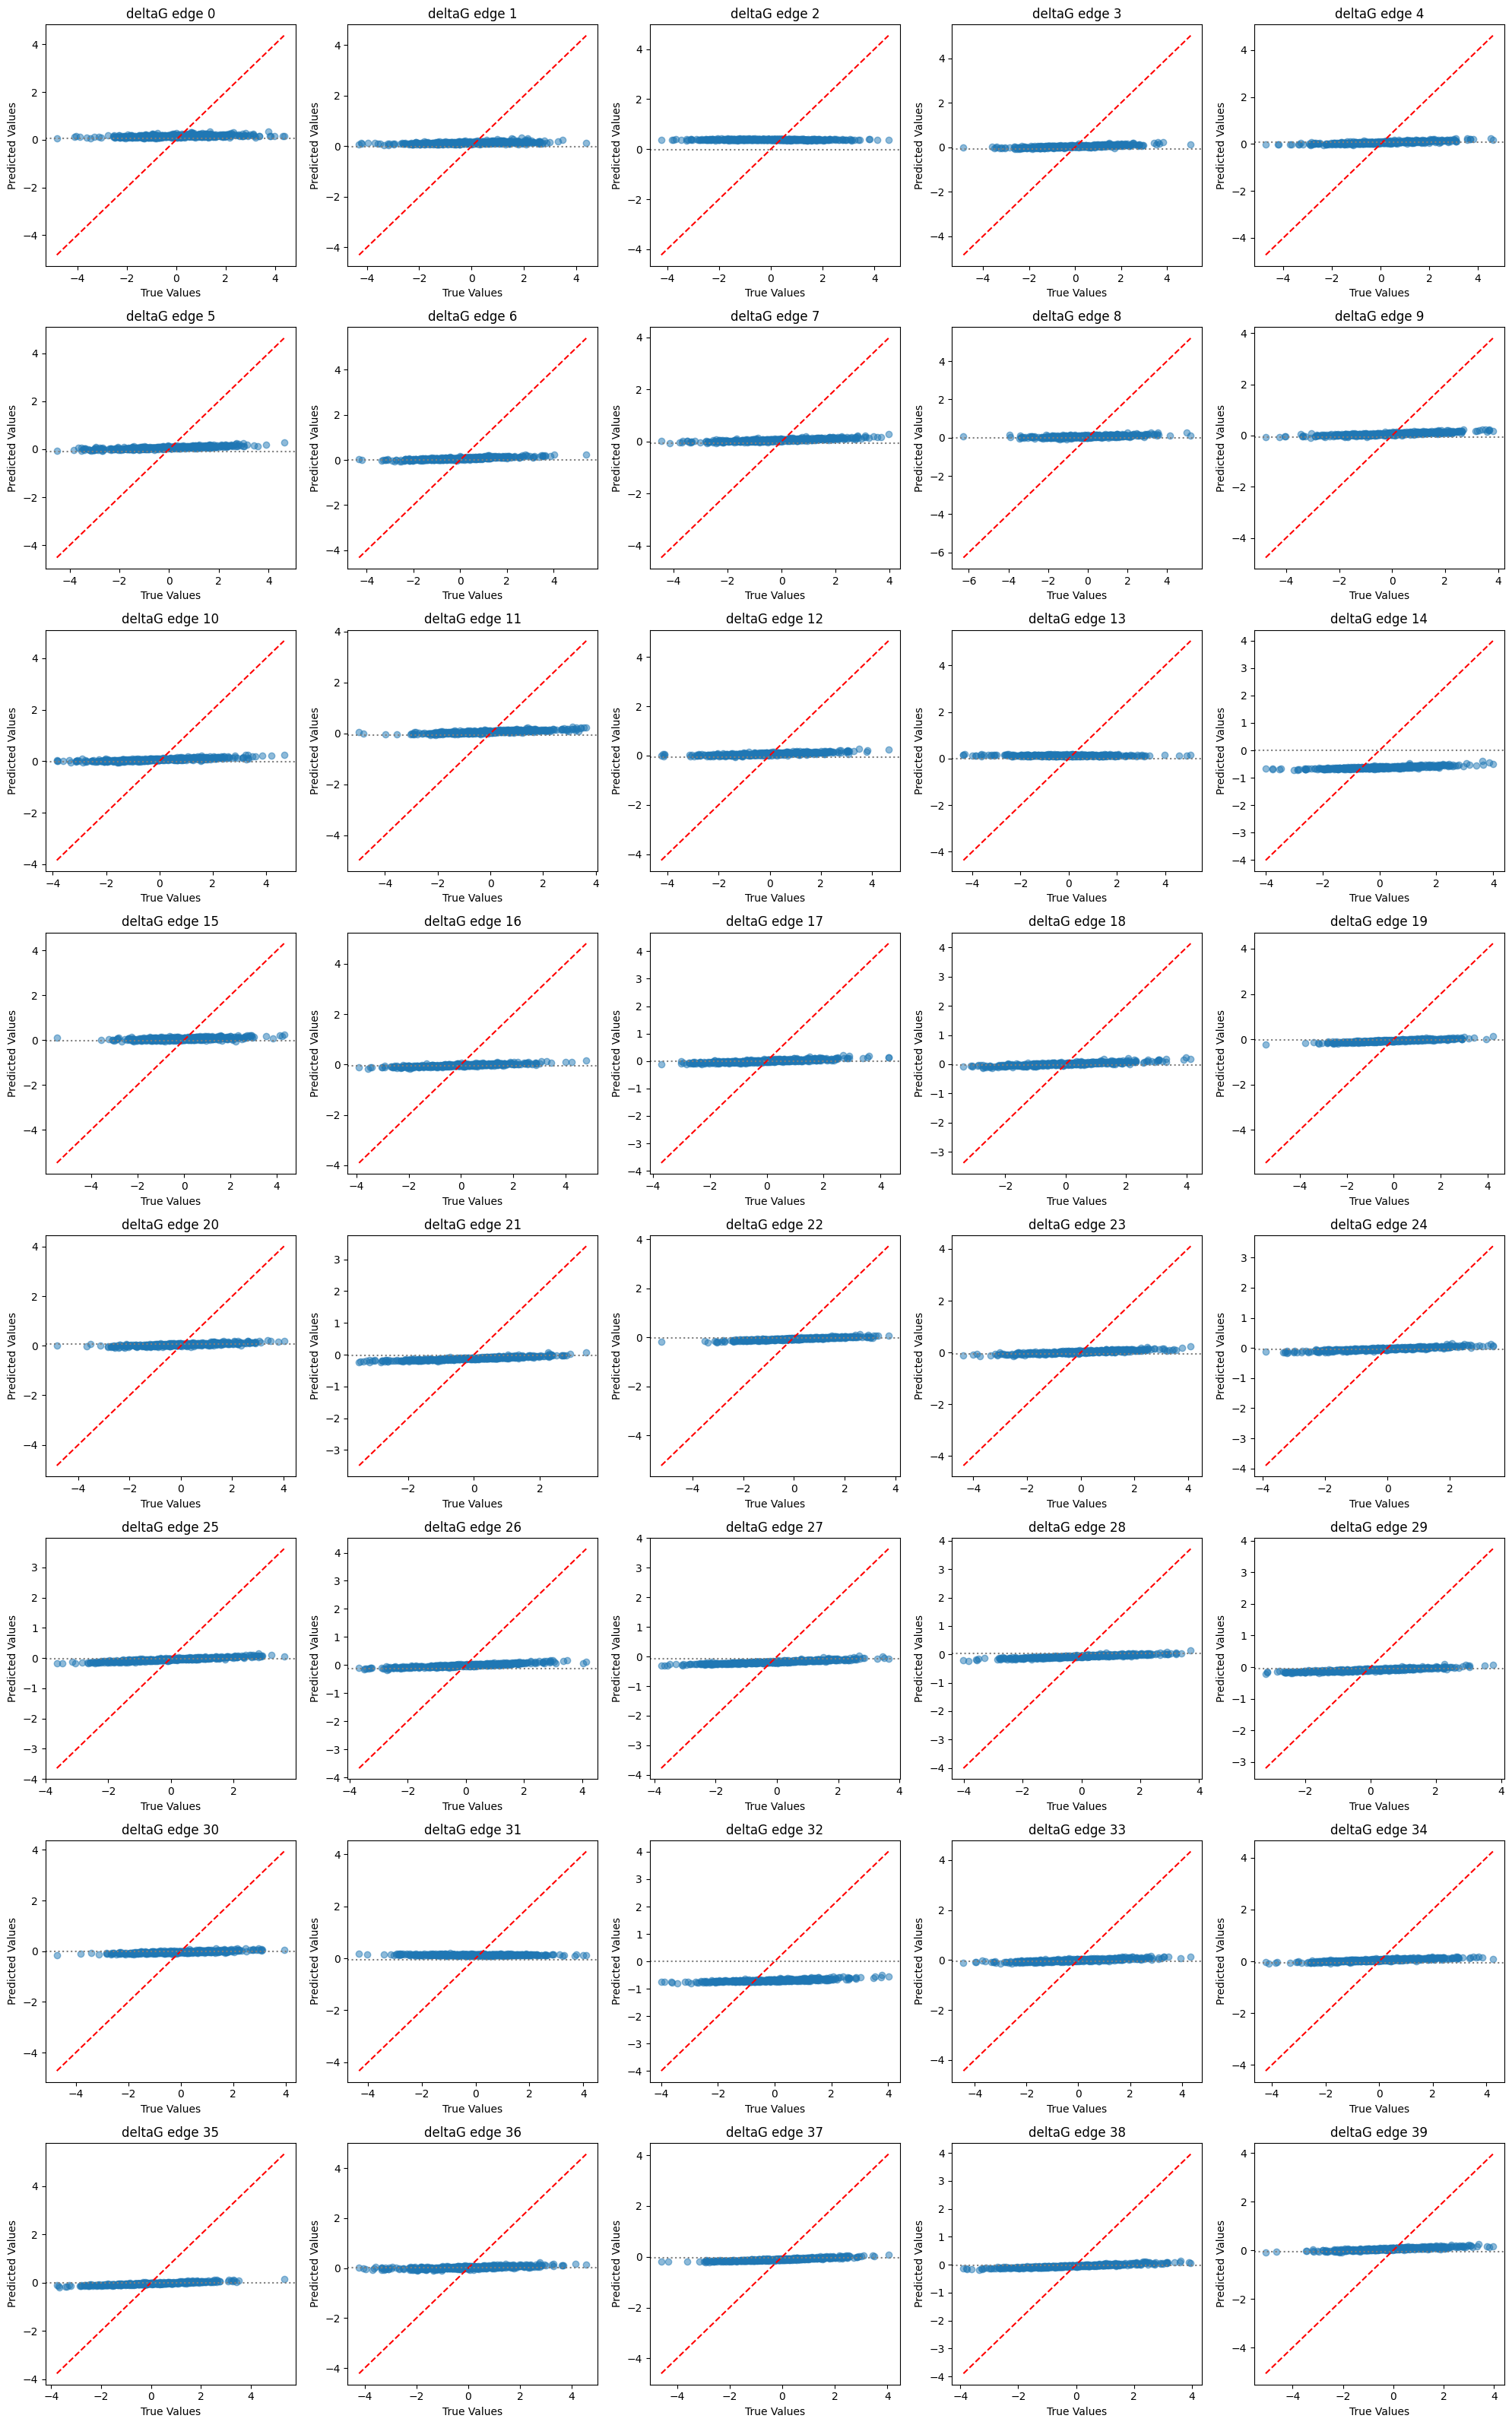

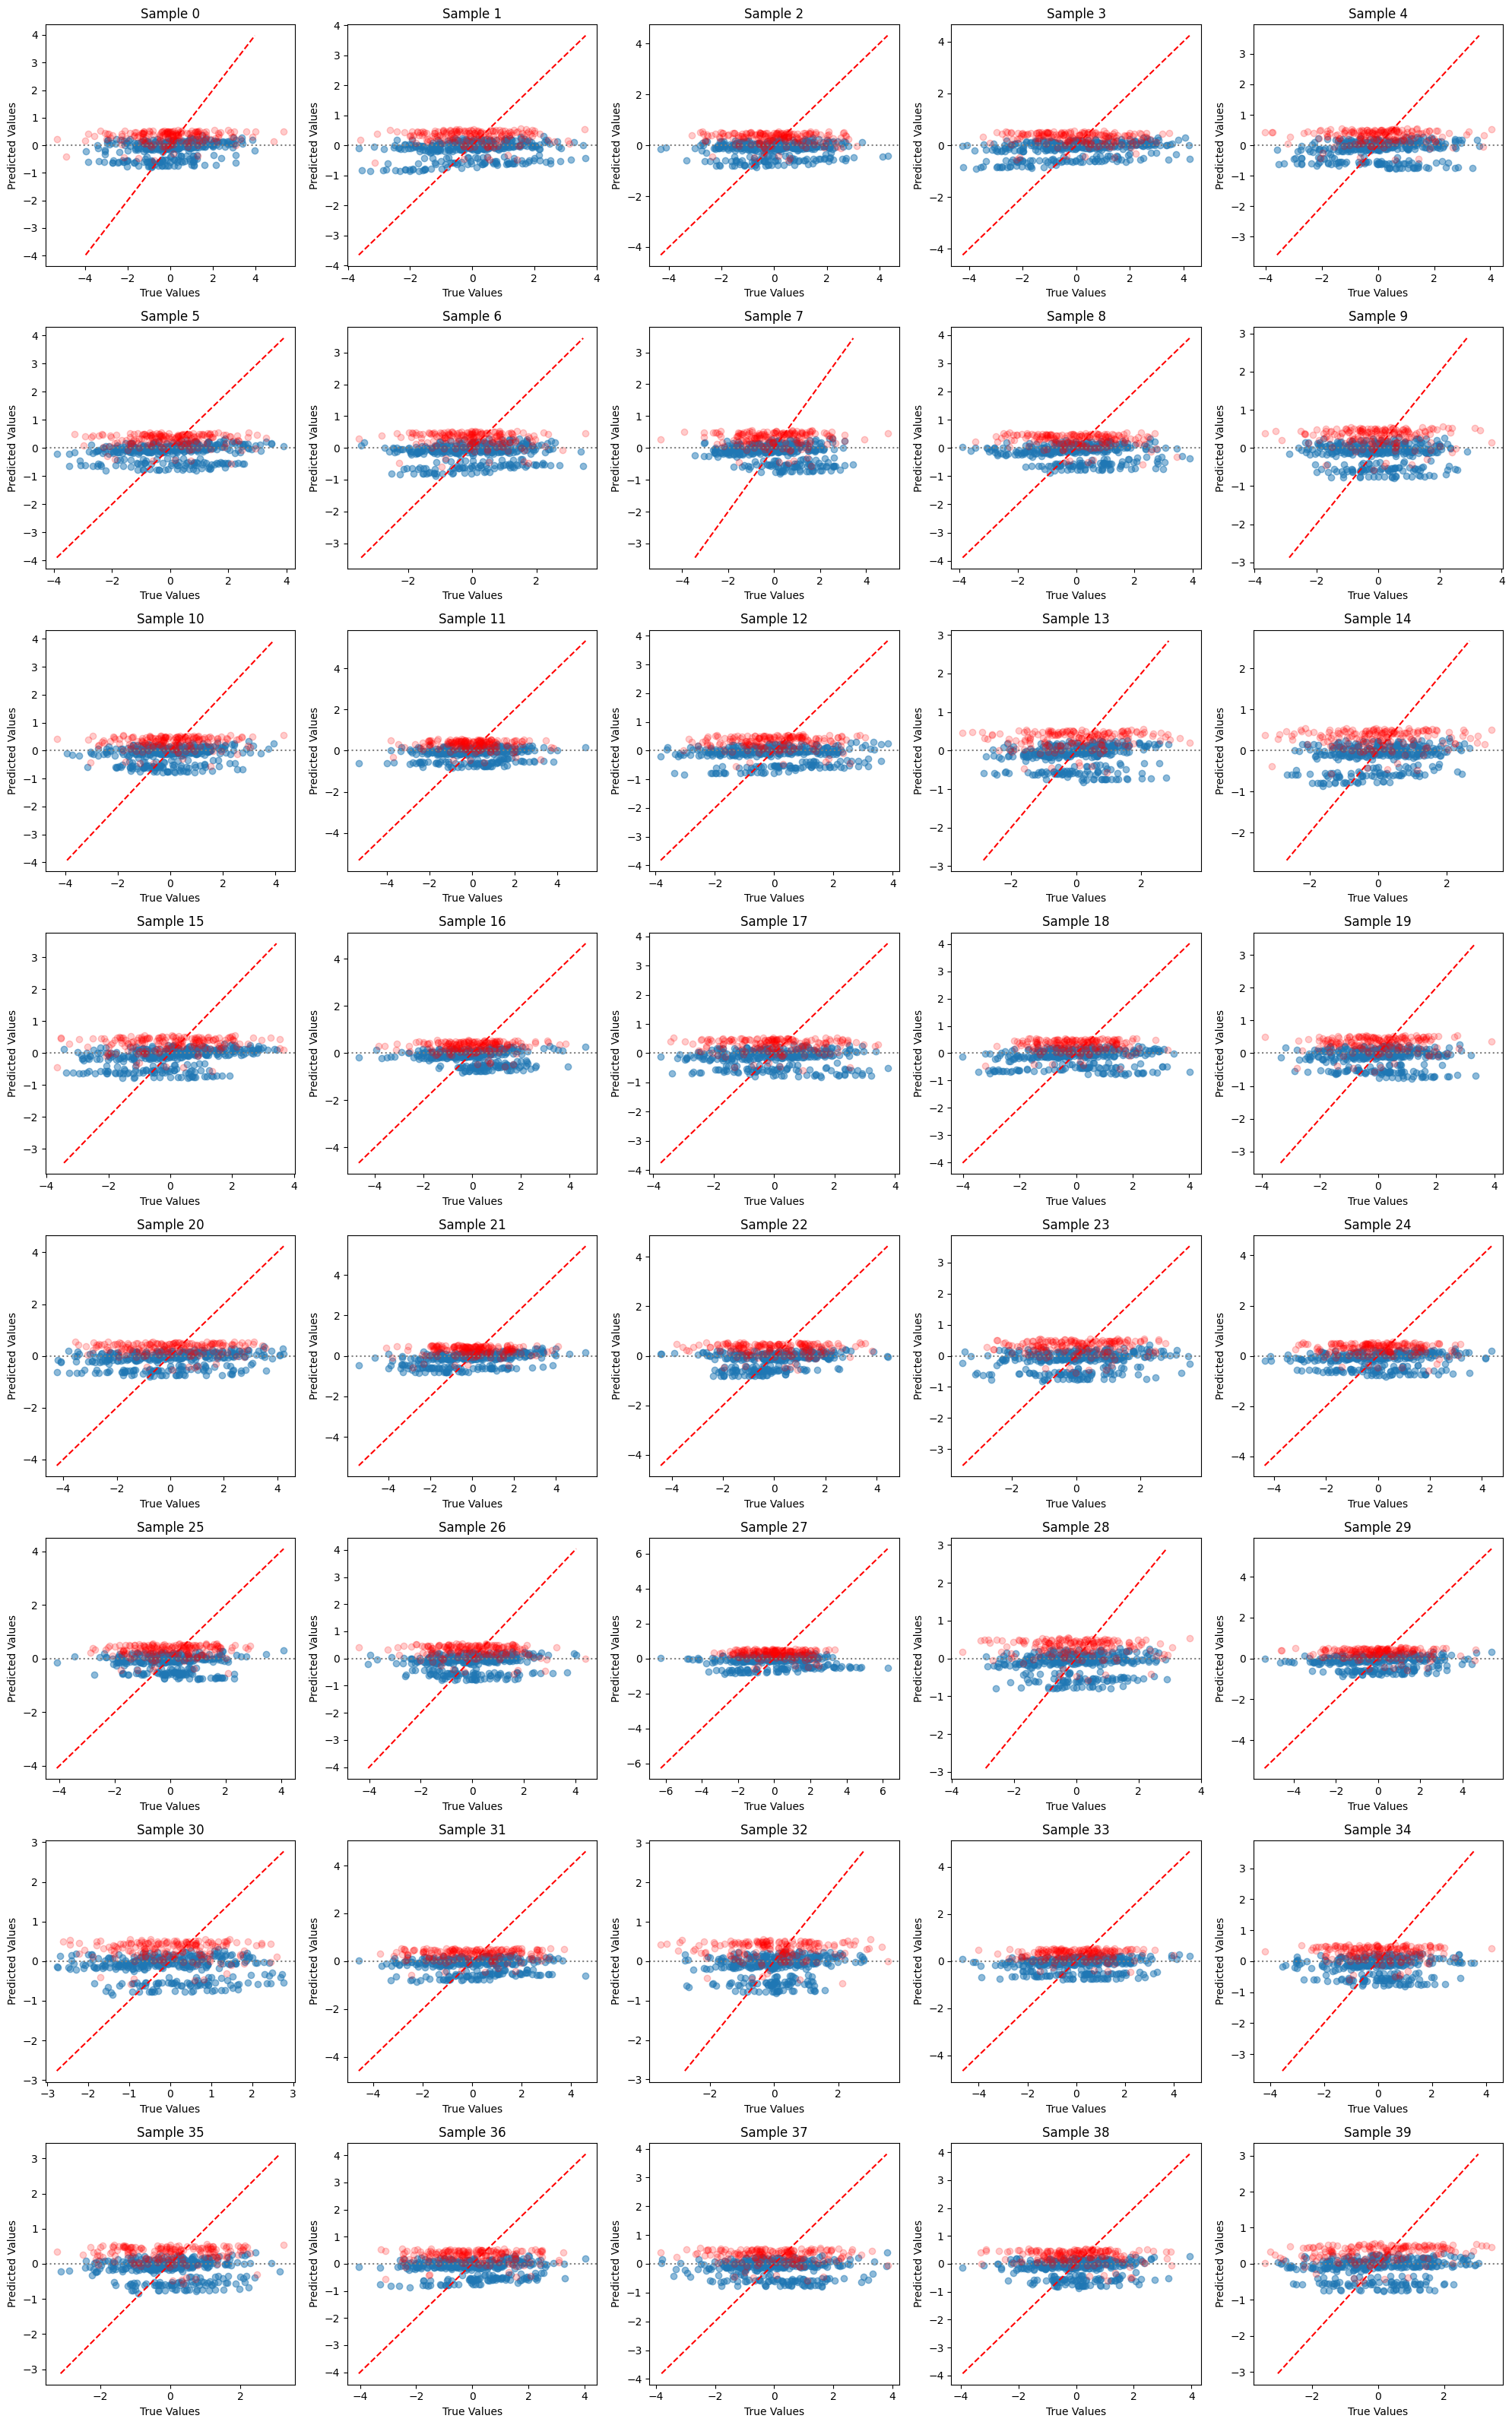

In [27]:
plot_results(deltaG_true, deltaG_pred, title='deltaG edge ')
plot_results(deltaG_true, deltaG_pred, title='Sample ', per_sample=True, points_to_color=edges_to_baths)

In [20]:
import torch
import os

ckpt = 2
# --- CONFIGURATION ---
# Replace these with your actual file paths
model_path = os.path.join(ckpt_dir, f'model_checkpoint_epoch_{ckpt}.pt')
optim_path = os.path.join(ckpt_dir, f'optimizer_checkpoint_epoch_{ckpt}.pt')

# 1. Load the Checkpoints
print(f"Loading {model_path} and {optim_path}...")
model_state = torch.load(model_path, map_location='cpu')
optim_state = torch.load(optim_path, map_location='cpu')

# 2. Get the Parameter Map
# The optimizer stores params in the exact order they appear in the model.
# We extract the 'state' dictionary which contains the momentum buffers.
optim_internals = optim_state['state']
param_groups = optim_state['param_groups']

# Extract the list of parameter IDs used by the optimizer
# (Usually there is only 1 param_group, unless you used different learning rates)
param_ids = param_groups[0]['params'] 

print(f"\n{'LAYER NAME':<40} | {'STATUS':<15} | {'GRAD SIGNAL (exp_avg)':<20}")
print("-" * 85)

# 3. Iterate through Model Parameters and Match with Optimizer State
# model_state.keys() gives us the layer names
# param_ids gives us the optimizer's internal ID for that layer
for i, (layer_name, _) in enumerate(model_state.items()):
    
    # Safety check: Ensure we don't go out of bounds if lengths differ
    if i >= len(param_ids): break
    
    pid = param_ids[i]
    
    # Check if this parameter has a stored state in the optimizer
    if pid in optim_internals:
        stats = optim_internals[pid]
        
        # 'exp_avg' is the Moving Average of the Gradient (Momentum)
        if 'exp_avg' in stats:
            grad_avg = stats['exp_avg']
            
            # Calculate magnitude (average absolute value)
            magnitude = torch.mean(torch.abs(grad_avg)).item()
            
            # Formatting the output
            status = "HEALTHY"
            if magnitude < 1e-6: status = "DEAD/SATURATED"
            elif magnitude > 100: status = "EXPLODING"
            
            print(f"{layer_name:<40} | {status:<15} | {magnitude:.2e}")
        else:
            print(f"{layer_name:<40} | {'NO MOMENTUM':<15} | N/A")
    else:
        # Some params (like buffers) might not be updated by the optimizer
        print(f"{layer_name:<40} | {'NOT TRAINED':<15} | N/A")

print("-" * 85)

Loading ../model_checkpoints\model_checkpoint_epoch_2.pt and ../model_checkpoints\optimizer_checkpoint_epoch_2.pt...

LAYER NAME                               | STATUS          | GRAD SIGNAL (exp_avg)
-------------------------------------------------------------------------------------
embed.mlp.0.weight                       | HEALTHY         | 9.66e-03
embed.mlp.0.bias                         | HEALTHY         | 6.64e-03
embed.mlp.1.weight                       | HEALTHY         | 1.20e-01
embed.mlp.3.weight                       | HEALTHY         | 1.78e-03
embed.mlp.3.bias                         | HEALTHY         | 4.93e-03
embed.mlp.4.weight                       | HEALTHY         | 1.24e-01
embed.mlp.5.weight                       | HEALTHY         | 2.33e-03
embed.mlp.5.bias                         | HEALTHY         | 6.78e-03
graph_encoder.mlp.0.weight               | HEALTHY         | 6.74e-04
graph_encoder.mlp.0.bias                 | HEALTHY         | 1.65e-03
graph_encoder

In [ ]:
def kinetic_constants_to_equilibrium_constants(log_kinetic_constants, adj_matrix):
    num_nodes = adj_matrix.shape[0]
    num_samples = log_kinetic_constants.shape[1]
    num_reactions = np.sum(adj_matrix, dtype=int) // 2
    K_eq = np.ones((num_reactions, num_samples))
    counter = 0
    for i in range(num_nodes):
        connected_indices = np.where(adj_matrix[i] == 1)[0]
        for j in connected_indices:
            if i < j:  # To avoid double counting
                reaction_index = np.sum(adj_matrix[:i], dtype=int) + np.sum(adj_matrix[i, :j], dtype=int)
                k_forward = log_kinetic_constants[reaction_index]
                k_reverse = log_kinetic_constants[np.sum(adj_matrix[:j], dtype=int) + np.sum(adj_matrix[j, :i], dtype=int)]
                print(f'Reaction {counter}: k_forward index {reaction_index}, k_reverse index {np.sum(adj_matrix[:j], dtype=int) + np.sum(adj_matrix[j, :i], dtype=int)}')
                K_eq[counter] = k_forward - k_reverse
                counter += 1
    return K_eq

num_reactions = np.sum(adj_matrix, dtype=int) // 2
Ks_pred = kinetic_constants_to_equilibrium_constants(np.array(ks_pred), adj_matrix)
Ks_true = kinetic_constants_to_equilibrium_constants(np.array(ks_true), adj_matrix)
Ks_bath_true = ks_prod_true - ks_deg_true
Ks_bath_pred = ks_prod_pred - ks_deg_pred

In [ ]:
indexes = np.argsort(num_cycles_per_edge[::5])[:40]
print(np.sort(num_cycles_per_edge[::5])[:40])
plot_results(Ks_true, Ks_pred, title='Equilibrium Constant ', indexes=indexes)
plot_results(Ks_true, Ks_pred, title='Sample ', per_sample=True, indexes=indexes)

In [ ]:
plot_results(Ks_bath_true, Ks_bath_pred, title='Equilibrium Constant ')
plot_results(Ks_bath_true, Ks_bath_pred, title='Sample ', per_sample=True)

In [ ]:
for batch in test_loader:
    _, _, embeddings = model(batch.x, batch.edge_index, batch.batch, return_embeddings=True)
    # 3. Check for Oversmoothing (Standard Deviation)
    # Calculate the standard deviation across nodes for each feature dimension
    # Shape of embeddings: [Num_Nodes, Hidden_Channels]
    std_per_feature = torch.std(embeddings, dim=0)

    # The average standard deviation across all features
    avg_diversity = std_per_feature.mean().item()

    print(f"Average Node Diversity (Std Dev): {avg_diversity:.6f}")

    # DIAGNOSIS:
    if avg_diversity < 1e-2:
        print("CRITICAL: Your nodes have collapsed (Oversmoothing). They are all the same.")
    elif avg_diversity < 1e-1:
        print("WARNING: Low diversity. Potential saturation or smoothing.")
    else:
        print("HEALTHY: Nodes have distinct representations.")
    

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
embeddings_list = []
for batch in test_loader:
    _, _, embeddings = model(batch.x, batch.edge_index, batch.batch, return_embeddings=True)
    embeddings_list.append(embeddings)

embeddings_all = torch.cat(embeddings_list, dim=0).detach().cpu().numpy()
'''tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_all)
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)
ax.set_title("t-SNE Visualization of Node Embeddings")
plt.show()'''

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
embeddings_pca = pca.fit_transform(embeddings_all)
explained_variance = pca.explained_variance_ratio_
print("Explained variance by each principal component:")
for i, var in enumerate(explained_variance):
    print(f"PC {i+1}: {var:.4f}")


In [ ]:
simulator = Simulator()
mask = np.where(adj_matrix == 1)
nodes_to_track = [i for i in range(adj_matrix.shape[0])]
true_kinetic_constants = np.full_like(adj_matrix, fill_value=-np.inf)
true_kinetic_constants[mask] = ks_true[:,0]
predicted_kinetic_constants = np.full_like(adj_matrix, fill_value=-np.inf)
predicted_kinetic_constants[mask] = ks_pred[:,0]
kin = np.stack([true_kinetic_constants, predicted_kinetic_constants])
prod = np.stack([ks_prod_true.T[0,:], ks_prod_true.T[0,:]])
deg = np.stack([ks_deg_true.T[0,:], ks_deg_true.T[0,:]])
print(kin.shape, prod.shape, deg.shape)
simulator.set_simulation_parameters(log_kinetic_constants=kin,
                                    log_production_constants=prod,
                                    log_degradation_constants=deg)
simulator.run_equilibration(track_concentrations=nodes_to_track[5::10], track_reference=True)

In [ ]:
import seaborn as sns
from scipy.cluster.hierarchy import fcluster
from pyvis.network import Network
import networkx as nx

correlation_matrix_partial = pd.read_csv('../simulation/correlation_matrix.csv', index_col=0)
symm_adj_df = pd.DataFrame(adj_matrix, index=adj_matrix_df.index, columns=adj_matrix_df.columns)
# add columns and rows to correlation matrix to match the adjacency matrix
correlation_matrix_partial = correlation_matrix_partial.reindex(index=symm_adj_df.index, columns=symm_adj_df.columns, fill_value=0)
# set digonal to 1
np.fill_diagonal(correlation_matrix_partial.values, 1)
ax = sns.clustermap(correlation_matrix_partial, cmap='coolwarm', cbar=True, vmin=-1, vmax=1, annot=False)
linkage_matrix = ax.dendrogram_row.linkage
num_clusters = 2
cluster_labels = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')
clean_labels = cluster_labels.tolist()
for i in range(num_clusters):
    cluster_list = [adj_matrix_df.index[j] for j in range(len(cluster_labels)) if clean_labels[j] == i+1]
    print(f'Cluster {i+1}: {cluster_list} \nCluster Size: {len(cluster_list)}\n')

node_to_cluster = {adj_matrix_df.index[i]: clean_labels[i] for i in range(len(cluster_labels))}


G = nx.from_pandas_adjacency(symm_adj_df)
nx.set_node_attributes(G, node_to_cluster, name='group')
for node, group_id in node_to_cluster.items():
    # The 'title' attribute controls what shows up on Hover
    # We can use HTML inside this string (e.g., <br> for new lines)
    G.nodes[node]['title'] = f"Cluster {group_id}"
    G.nodes[node]['group'] = group_id
# 2. Create the PyVis network
net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white", cdn_resources='remote')

# 3. Translate from NetworkX to PyVis
net.from_nx(G)

# 4. Add physics controls (optional, helps you tweak the layout in real-time)
net.show_buttons(filter_=['physics'])

# 5. Save and show
net.show(f"{num_clusters}_clusters.html")
ax


In [ ]:
for graph in test_dataset:
    for i, edge in enumerate(graph.edge_index.T):
        print(edge, i)
    break
